In [1]:
import psutil
import gc
import gym
import dmc2gym
import numpy as np
import torch
import torch.optim as optim
from gym import spaces
from torch.autograd import Variable

import gym
import scipy.optimize

from models import *
from replay_memory import Memory
from running_state import ZFilter
from trpo import trpo_step, get_trpo_tar_mean_adv, get_atrpo_tar_adv
from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt

torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

torch.set_default_tensor_type('torch.DoubleTensor')

/home/arkadiy/.local/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
def update_params(batch, targ_adv_fun):
    vloss = []
    ploss = []
    rewards = torch.tensor(np.array(batch.reward))
    masks = torch.tensor(np.array(batch.mask))
    actions = torch.Tensor(np.concatenate(batch.action, 0)).detach()
    states = torch.tensor(np.array(batch.state)).detach()
    values = val(states)

    targets, advantages = targ_adv_fun(rewards, masks, actions, values)

    targets = targets.detach()
    advantages = advantages.detach()

    # Original code uses the same LBFGS to optimize the value loss
    def get_value_loss(flat_params):
        set_flat_params_to(val, torch.Tensor(flat_params))
        for param in val.parameters():
            if param.grad is not None:
                param.grad.data.fill_(0)

        value_loss = (val(states) - targets).pow(2).mean()
        vloss.append(value_loss)

        # weight decay
        for param in val.parameters():
            value_loss += param.pow(2).sum() * l2_reg
        value_loss.backward()
        return (value_loss.data.double().numpy(), get_flat_grad_from(val).data.double().numpy())

    flat_params, _, opt_info = scipy.optimize.fmin_l_bfgs_b(get_value_loss, get_flat_params_from(val).double().numpy(), maxiter=40)
    set_flat_params_to(val, torch.Tensor(flat_params))

    action_means, action_log_stds, action_stds = agent(states)
    fixed_log_prob = normal_log_density(actions, action_means, action_log_stds, action_stds).data.clone().detach()

    def get_loss(volatile=False):
        if volatile:
            with torch.no_grad():
                action_means, action_log_stds, action_stds = agent(states)
        else:
            action_means, action_log_stds, action_stds = agent(states)
                
        log_prob = normal_log_density(actions, action_means, action_log_stds, action_stds)
        action_loss = -(advantages * torch.exp(log_prob - fixed_log_prob))
        return action_loss.mean()


    def get_kl():
        mean1, log_std1, std1 = agent(states)

        mean0 = mean1.data.detach()
        log_std0 = log_std1.data.detach()
        std0 = std1.data.detach()
        kl = log_std1 - log_std0 + (std0.pow(2) + (mean0 - mean1).pow(2)) / (2.0 * std1.pow(2)) - 0.5
        return kl.sum(1, keepdim=True)

    policy_loss = trpo_step(agent, get_loss, get_kl, max_kl, damping)
    ploss.append(policy_loss)
    return vloss, ploss, advantages


In [3]:
domain_name = 'cartpole'
task_name = 'balance'
model_file = f'data/models/{domain_name}_{task_name}'
seed = 1597
l2_reg = 1e-2
max_kl = 0.01#1e-2
damping = 1e-1

In [4]:
#get_trpo_tar_mean_adv - trpo with normed advantege
#get_atrpo_tar_mean_adv - atrpo with normed advantege (Bad)
#get_atrpo_tar_adv_0 - atrpo with masks
#get_atrpo_tar_adv_1 - atrpo without masks

render = False
compare_plots = True
plt.figure(figsize=(5,3))
targ_adv_funs = [get_atrpo_tar_adv]#[get_atrpo_tar_adv, get_trpo_tar_mean_adv]

ext_its = 1 #num of experiments
i_episodes = 5 # number of batches in an experiment

t_steps = 1000 # path len
batch_size = 10000 # t_steps * (?)
log_interval = max(1,-i_episodes//100)


<Figure size 360x216 with 0 Axes>

In [5]:
targ_adv_funs_len = len(targ_adv_funs)
all_acc_batch_rewards = [[] for i in range(len(targ_adv_funs))]

In [6]:
agent = None
val = None

In [7]:
for ext_it in tqdm(range(ext_its * targ_adv_funs_len)):
    cur_exp_id = ext_it // targ_adv_funs_len
    cur_f_id = ext_it % targ_adv_funs_len
    cur_targ_adv_func = targ_adv_funs[cur_f_id]
    cur_seed = seed + cur_exp_id

    #env = gym.make(env_name, terminate_when_unhealthy = False)
    env = dmc2gym.make(domain_name=domain_name, task_name=task_name, seed=cur_seed)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]
    env.seed(cur_seed)
    torch.manual_seed(cur_seed)
    agent = ATRPOAgent(num_inputs, num_actions, 128)
    val = Value(num_inputs, 128)
    val_opt = optim.Adam(val.parameters(), lr=1e-3)
    
    running_state = ZFilter((num_inputs,), clip=5)
    running_reward = ZFilter((1,), demean=False, clip=10)
    acc_batch_rewards = []

    for i_episode in range(i_episodes):
        memory = Memory()

        num_steps = 0
        reward_batch = 0
        num_episodes = 0
        while num_steps < batch_size:
            state = env.reset()
            state = running_state(state)

            reward_sum = 0
            for t in range(t_steps):
                action = agent.act(state)
                #action = torch.clamp(action, -1, 1)
                #action.type(torch.FloatTensor)
                cast_action = torch.tensor(action, dtype=torch.float32)
                #print(action, type(action))
                cast_action = cast_action.cpu().data.numpy().flatten()
                #action = action.data[0].numpy()
                #print(action, type(action))
                next_state, reward, done, _ = env.step(cast_action)
                reward_sum += reward

                next_state = running_state(next_state)

                mask = 0 if done else 1

                memory.push(state, np.array([action.cpu().data[0].numpy()]), mask, next_state, reward)

                if render:
                    env.render()
                if done:
                    break

                state = next_state
            num_steps += (t-1)
            num_episodes += 1
            reward_batch += reward_sum

        reward_batch /= num_episodes
        acc_batch_rewards.append(reward_batch)
        batch = memory.sample()
        for _ in range(2):
            vloss , ploss, advs = update_params(batch,cur_targ_adv_func)

        if i_episode % log_interval == 0:
            print('Episode {}\tFunc name: {}\tAverage reward {:.2f}, PLoss {}\t VLoss {}\t Advs {}'.format(
                i_episode, cur_targ_adv_func.__name__, reward_batch, Average(ploss).item(), Average(vloss).item(),Average(advs).item()))
            
    save_file=f'{model_file}_{cur_targ_adv_func.__name__}_exp{cur_exp_id}_seed{cur_seed}_iter{i_episodes}'
    print("Saving model:", save_file)
    torch.save(agent, save_file+'_agent.pt')
    torch.save(val, save_file+'_value.pt')

    plt.title(cur_targ_adv_func.__name__)

    plt.plot(acc_batch_rewards)
    plt.show()

    all_acc_batch_rewards[cur_f_id].append(acc_batch_rewards)

    if targ_adv_funs_len > 1 and compare_plots and cur_f_id == targ_adv_funs_len-1:
        plt.title(cur_exp_id)
        for i in range(targ_adv_funs_len):
            plt.plot(all_acc_batch_rewards[i][-1],label=targ_adv_funs[i].__name__)
        plt.legend()
        plt.show()
    gc.collect(); torch.cuda.empty_cache()

  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/arkadiy/.local/lib/python3.8/site-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/home/arkadiy/.local/lib/python3.8/site-packages/dmc2gym/wrappers.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim = np.int(np.prod(s.shape))
/home/arkadiy/.local/lib/python3.8/site-packages/gym/core.py:317: DeprecationWa

Episode 0	Func name: get_atrpo_tar_adv	Average reward 340.48, PLoss 0.00022599488337170988	 VLoss 0.060331190002194106	 Advs -0.00022599488337170926
Episode 1	Func name: get_atrpo_tar_adv	Average reward 300.21, PLoss 0.000814933458275823	 VLoss 0.11793580863192357	 Advs -0.0008149334582758161
Episode 2	Func name: get_atrpo_tar_adv	Average reward 257.10, PLoss 0.0015782804137635495	 VLoss 0.19526238795829645	 Advs -0.001578280413763538
Episode 3	Func name: get_atrpo_tar_adv	Average reward 218.28, PLoss 0.002579697083208523	 VLoss 0.2703368089513469	 Advs -0.0025796970832085296


  0%|                                                     | 0/1 [02:22<?, ?it/s]

Episode 4	Func name: get_atrpo_tar_adv	Average reward 222.15, PLoss 0.0037418611083356867	 VLoss 0.34766928122630136	 Advs -0.003741861108335696
Saving model: data/models/cartpole_balance_get_atrpo_tar_adv_exp0_seed1597_iter5


RuntimeError: Parent directory data/models does not exist.

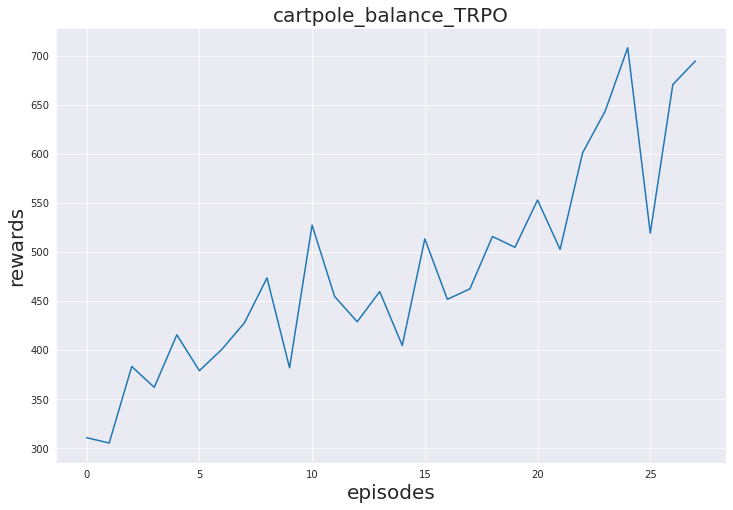

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#42

agent_name = f'{domain_name}_{task_name}_TRPO'


sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.title(agent_name, size=20)
plt.xlabel("episodes", size=20)
plt.ylabel("rewards", size=20)
plt.plot(acc_batch_rewards)
#plt.savefig(f'{plot_directory}{agent_name}')
plt.show()